In [2]:
from scipy import sparse
import numpy as np
import itertools
import copy

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import gaussian_kde
from tqdm import tqdm_notebook
from seaborn import kdeplot

import sys
sys.path.append("..")
import utils

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [3]:
interaction_matrix = sparse.load_npz('../data/interaction_matrix_pchembl.npz')
##interaction_matrix = np.array(interaction_matrix.todense())
#
interaction_dates = sparse.load_npz('../data/interaction_dates_pchembl.npz')
##interaction_dates = np.array(interaction_dates.todense())

The publication dates of the interactions are recorded in ChEMBL. Looking below we can see the distribution of years: 

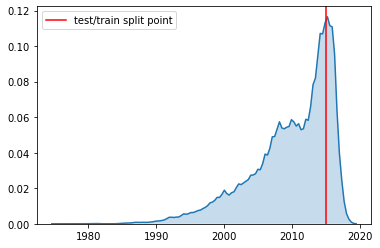

In [4]:
#removing 'year=1' which were originally NaNs in ChEMBL:
_ = kdeplot(interaction_dates.data[interaction_dates.data>1950], shade=True)
#bonus - set 'cumulative=True' in kdeplot to visualize the amount of data that will be in the test set.
plt.axvline(2015, c='red', label='test/train split point')
plt.legend()

These can thus be used to perform time-split cross validation, which simulates prospective validation. The below sets a year, and creates a training matrix with all interactions equal to or before that year, and a test matrix with all interactions from after that year. 

In [5]:
#train, test = utils.load_time_split()

In [6]:
#sparse.csr_matrix(train)

In [7]:
# interaction_matrix = utils.load_subset()

In [8]:
#train, test = utils.train_test_split(interaction_matrix, 0.05)

In [ ]:
%%time
train, test = utils.load_time_split()
name = 'hpo_implicit_bpr'
params = utils.read_params(name)
preds = utils.train_implicit_bpr(params, train)
ranks = utils.evaluate_predictions(preds, test, train)
mean, median, kde, ecdf = score_ranks(ranks)
print(mean, median)
for _ in range(16):
    preds+=utils.train_implicit_bpr(params, train)
    ranks = utils.evaluate_predictions(preds, test, train)
    mean, median, kde, ecdf = score_ranks(ranks)
    print(mean, median)


In [9]:
%%time
train, test = utils.load_time_split()
name = 'hpo_implicit_bpr'
params = utils.read_params(name)
preds_imp = utils.train_implicit_bpr(params, train)
#ranks = utils.evaluate_predictions(preds, test, train)
#mean, median, kde, ecdf = score_ranks(ranks)
#print(mean, median)
for _ in tqdm_notebook(range(1)):
    preds_imp+=utils.train_implicit_bpr(params, train)
    #ranks = utils.evaluate_predictions(preds, test, train)
    #mean, median, kde, ecdf = score_ranks(ranks)
    #print(mean, median)


CPU times: user 5.17 s, sys: 355 ms, total: 5.53 s
Wall time: 5.32 s


In [12]:
ranks_imp = utils.evaluate_predictions(preds_imp, test, train)

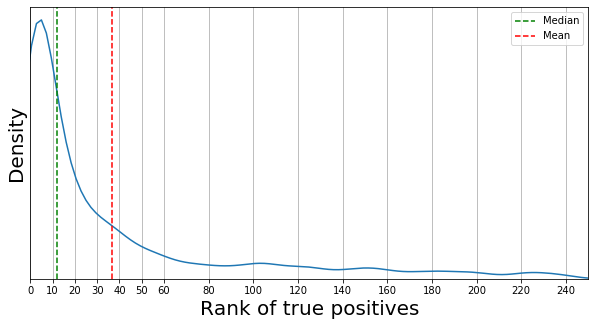

In [46]:
plt.figure(figsize=(10,5))
kdeplot(ranks_imp)
plt.xticks(np.concatenate([np.arange(0,51,10), np.arange(60,250,20)]))
plt.yticks([])
plt.xlim(0,250)
plt.grid()

plt.axvline(np.median(ranks_imp), label='Median', c='green',linestyle='--')
plt.axvline(np.mean(ranks_imp), label='Mean',c='red',linestyle='--')
plt.legend()
plt.ylabel('Density', fontsize=20)
plt.xlabel('Rank of true positives', fontsize=20)
plt.savefig('ranks_dist.png')

In [22]:
np.concatenate([np.arange(0,100,10), np.arange(100,250,20)])

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 120, 140,
       160, 180, 200, 220, 240])

In [8]:
ranks_imp = utils.evaluate_predictions(preds_imp, test, train)

In [ ]:
#median corresponds to the minimum of the l1 norm! 
#https://statmodeling.stat.columbia.edu/2006/11/16/bayesian-inference-median/
l1norm=list()
for i in np.linspace(1,25,500):
    diffs = np.abs(i-ranks_imp)
    l1norm.append(np.sum(diffs))

In [ ]:
np.argmin(l1norm)

In [ ]:
np.linspace(1,25,500)[187]

In [ ]:
np.median(ranks_imp)

In [1]:
ranks

NameError: name 'ranks' is not defined

In [ ]:
plt.plot(np.linspace(1,25,500),l1norm)

In [ ]:
ranks_imp

In [9]:
#Laplace distribution is related to l1 norm. 
#so we could use laplace as the likelihood for pymc3:

import pymc3 as pm

with pm.Model() as model:
    #prior:
    m = pm.Normal('m', mu=5, sigma=6.0)
    bee = pm.HalfNormal('bee', sigma=6.0)
    #likelihood:
    y = pm.Laplace('y', mu=m, b=bee,observed=ranks_imp)

In [10]:
with model:
    trace = pm.sample(draws=500, tune=500, chains=2,
                      target_accept=0.9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bee, m]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1168.69draws/s]


In [ ]:
kdeplot(trace['m'])
plt.vlines(pm.stats.hpd(trace['m']),0,0.6)

In [ ]:
pm.plots.plot_posterior(trace, var_names=['m'])
plt.savefig('hi')

In [ ]:
kdeplot(trace['bee'])
plt.vlines(pm.stats.hpd(trace['bee']),0,0.6)

In [ ]:
from scipy import stats
plt.plot(np.linspace(-20,40,100), [stats.laplace(10.5,31).pdf(i) for i in np.linspace(-20,40,100)])


In [ ]:
pm.stats.hpd(trace['m'])

In [ ]:
pm.traceplot(trace, var_names=['m'])

In [ ]:
trace['m']

In [ ]:
import scikits.bootstrap as boot
#import numpy as np
boot.ci(ranks, np.median, n_samples=100)


In [ ]:
len(ranks)

In [ ]:
medians = list()
for _ in range(1000):
    beep = np.random.choice(ranks, 500)
    medians.append(np.median(beep))

In [ ]:
sorted(medians)[25]

In [ ]:
sorted(medians)[975]

In [ ]:
plt.hist(medians,bins=250)
#kdeplot(medians)
plt.axvline(8, c='k')
plt.axvline(13, c='k')

In [ ]:
%%time
train, test = utils.load_time_split()
name = 'hpo_lightfm_warp'
params = utils.read_params(name)
preds_lfm = utils.train_lightfm_warp(params, train)
#ranks = utils.evaluate_predictions(preds, test, train)
#mean, median, kde, ecdf = score_ranks(ranks)
#print(mean, median)
for _ in tqdm_notebook(range(8)):
    preds_lfm+=utils.train_lightfm_warp(params, train)
    #ranks = utils.evaluate_predictions(preds, test, train)
    #mean, median, kde, ecdf = score_ranks(ranks)
    #print(mean, median)


In [ ]:
ranks_lfm = utils.evaluate_predictions(preds_lfm, test, train)

In [ ]:
np.vstack([ranks_lfm, ranks_imp]).T

In [ ]:
ranks_lfm

In [ ]:
import pandas as pd
bah = pd.DataFrame(data=np.vstack([ranks_lfm, ranks_imp]).T, columns=['lfm','bpr'])
bah.to_csv('lfm_vs_bpr.csv',index=False)

In [ ]:
%%time
train, test = utils.load_time_split()
name = 'hpo_lightfm_bpr'
params = utils.read_params(name)
preds_lfm_bpr = utils.train_lightfm_bpr(params, train)
for _ in tqdm_notebook(range(8)):
    preds_lfm_bpr+=utils.train_lightfm_warp(params, train)

In [ ]:
%%time
train, test = utils.load_time_split()
name = 'hpo_implicit_als'
params = utils.read_params(name)
preds_imp_als = utils.train_implicit_als(params, train)
for _ in tqdm_notebook(range(8)):
    preds_imp_als+=utils.train_implicit_als(params, train)

In [ ]:
ranks_lfm = utils.evaluate_predictions(preds_lfm, test, train)
ranks_imp = utils.evaluate_predictions(preds_imp, test, train)
mean_lfm,median_lfm,kde_lfm,ecdf_lfm = score_ranks(ranks_lfm)
mean_imp,median_imp,kde_imp,ecdf_imp = score_ranks(ranks_imp)

In [ ]:
ranks_lfm_bpr = utils.evaluate_predictions(preds_lfm_bpr, test, train)
ranks_imp_als = utils.evaluate_predictions(preds_imp_als, test, train)

mean_lfm_bpr,median_lfm_bpr,kde_lfm_bpr,ecdf_lfm_bpr = score_ranks(ranks_lfm_bpr)
mean_imp_als,median_imp_als,kde_imp_als,ecdf_imp_als = score_ranks(ranks_imp_als)

In [ ]:
ranks_geo = (ranks_lfm*ranks_imp*ranks_lfm_bpr)**(1/3)
ranks_geo = (ranks_lfm*ranks_imp)**(1/2)
ranks_geo = (ranks_lfm*ranks_lfm_bpr)**(1/2)
mean_geo,median_geo,kde_geo,ecdf_geo = score_ranks(ranks_geo)

In [ ]:
print(mean_geo, median_geo)

In [ ]:
median_imp_als

In [ ]:
print(mean_geo, median_geo)

In [ ]:
plt.plot(kde_lfm, label='lfm_warp')
plt.plot(kde_lfm_bpr, label='lfm_bpr')
plt.plot(kde_imp, label='imp_bpr')
plt.plot(kde_imp_als, label='imp_als')
plt.plot(kde_geo, label='geo')

plt.legend()
plt.xlim(0,20)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(ecdf_lfm, label='lfm_warp')
plt.plot(ecdf_lfm_bpr, label='lfm_bpr')
plt.plot(ecdf_imp, label='imp_bpr')
plt.plot(ecdf_imp_als, label='imp_als')
plt.plot(ecdf_geo, label='geo')

plt.legend()
plt.xlim(0,20)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(ecdf_lfm, label='lfm')
plt.plot(ecdf_imp, label='imp')
plt.plot(ecdf_geo, label='geo')
plt.legend()
plt.xlim(0,20)

In [ ]:
ranks_lfm

In [ ]:
ranks_imp

In [ ]:
print(mean, median)
plt.plot(kde)

In [ ]:
def score_ranks(ranks):
    
    #normal statistics:
    mean = np.mean(ranks)
    median = np.median(ranks)

    #kde:
    density = gaussian_kde(ranks)
    xs = np.linspace(0,243,243)
    density.covariance_factor= lambda : 0.25
    density._compute_covariance()

    #empirical cumulative distribution function:
    ecdf = [(ranks<i).sum()/len(ranks) for i in range(0, 243)]

    return mean, median, density(xs), ecdf

In [ ]:
year = 2010

#turn interaction dates into a masker
dates_mask = (interaction_dates.data<=year).astype(int)

#make copies that will become train / test matrices
train = copy.copy(interaction_matrix)
test = copy.copy(interaction_matrix)

#remove 2015 and later records from train matrix
train.data = train.data * dates_mask
#remove all training data from the test matrix. 
test.data = test.data - train.data

#remove any rows from the train matrix that have zero interactions.
#this is the case any time a new ligand is discovered in 2015 or after. 
#we can't use link prediction on new ligands! It's a cold start problem. 
#so we remove all these ligands from the present analysis. 
row_mask = np.array((train.sum(axis=1)!=0)).reshape(1,-1)[0] #there must be a cleaner way to do that.
train = train[row_mask] 
test = test[row_mask]

train.eliminate_zeros()
test.eliminate_zeros()

In [ ]:
name = 'hpo_implicit_bpr'
parameter_flag=False
params = dict()
for line in open('../hyperparameter_optimization/'+name+'.dat', 'r').readlines():
    if 'Result' in line:
        parameter_flag=False
    if parameter_flag:
        words = line.split()
        params[words[0]]=float(words[1])
        print(line.split())
    if 'Best parameters' in line:
        parameter_flag=True

In [ ]:
params

In [ ]:
utils.train_implicit_bpr(train)

In [ ]:
def score_ranks(ranks):
    
    #normal statistics:
    mean = np.mean(ranks)
    median = np.median(ranks)

    #kde:
    density = gaussian_kde(ranks)
    xs = np.linspace(0,243,243)
    density.covariance_factor= lambda : 0.25
    density._compute_covariance()

    #empirical cumulative distribution function:
    ecdf = [(ranks<i).sum()/len(ranks) for i in range(0, 243)]

    return mean, median, density(xs), ecdf

In [ ]:
mean, med, kde, ecdf = plot_ranks(ranks)

In [ ]:
from matplotlib.gridspec import GridSpec
fig, ax = plt.subplots(2,2)
gs = GridSpec(2, 2, width_ratios=[[6,2],[6,2]])
for i in range(4):
    ax[i][j].set_position(gs[i].get_position(fig))


In [ ]:
gs[4]

In [ ]:
#plt.plot(ecdf)
plt.plot(kde)

In [ ]:
def find_opt_pars(filename):
    f = open('../hyperparmeter_optimization/'+filename, 'r')
    record=False
    for line in f:
        if 'Paramaters:' in line:
            return [float(i) for i in line.strip('\n').replace('[', '').replace(']', '').replace(',', '').split()[1:]]


In [ ]:
pars = find_opt_pars('hpo_implicit_bpr.dat')
pars

In [ ]:
def train_implicit_bpr(pars, inp):
    model = implicit.bpr.BayesianPersonalizedRanking(factors=int(pars[0]),
                                                 learning_rate=pars[1],
                                                 regularization=pars[2],
                                                 iterations=int(pars[3]),
                                                 use_gpu=False)
    model.fit(sparse.csr_matrix(inp), show_progress=False)
    return np.dot(model.item_factors, model.user_factors.T)


pars = find_opt_pars('hpo_implicit_bpr.dat')
implicit_bpr_preds = train_implicit_bpr(pars, train)
for _ in range(7):
    implicit_bpr_preds += train_implicit_bpr(pars, train)
implicit_bpr_ranks = utils.evaluate_predictions(implicit_bpr_preds, test)

In [ ]:
def train_implicit_als(pars, inp):
    model = implicit.als.AlternatingLeastSquares(factors=params['factors'],
                                                 regularization=params['regularization'],
                                                 iterations=params['iterations'],
                                                 num_threads=1,
                                                 use_gpu=False)
    model.fit(train)
    return np.dot(model.item_factors, model.user_factors.T)
        #evaluate by calculating mean rank:
        results.append(utils.evaluate_predictions(pred_matrix, test).mean())

    return np.mean(results)

In [ ]:
import implicit
means = list()
medians = list()
kdes = list()

model = implicit.bpr.BayesianPersonalizedRanking(factors=337,
                                                learning_rate=0.06276,
                                                regularization=0.001147,
                                                iterations=25,
                                                use_gpu=False)
model.fit(train)

imbpr_preds = np.dot(model.item_factors, model.user_factors.T)
ranks = utils.evaluate_predictions(imbpr_preds, test)
m, med, kde = plot_ranks(ranks)
means.append(m)
medians.append(med)
kdes.append(kde)

for _ in range(5):
    model = implicit.bpr.BayesianPersonalizedRanking(factors=337,
                                                learning_rate=0.06276,
                                                regularization=0.001147,
                                                iterations=25,
                                                use_gpu=False)
    model.fit(train)

    imbpr_preds += np.dot(model.item_factors, model.user_factors.T)
    ranks = utils.evaluate_predictions(imbpr_preds, test)
    m, med, kde = plot_ranks(ranks)
    means.append(m)
    medians.append(med)
    kdes.append(kde)

In [ ]:
for _ in range(10):
    model = implicit.bpr.BayesianPersonalizedRanking(factors=337,
                                                learning_rate=0.06276,
                                                regularization=0.001147,
                                                iterations=25,
                                                use_gpu=False)
    model.fit(train)

    imbpr_preds += np.dot(model.item_factors, model.user_factors.T)
    ranks = utils.evaluate_predictions(imbpr_preds, test)
    m, med, kde = plot_ranks(ranks)
    means.append(m)
    medians.append(med)
    kdes.append(kde)

In [ ]:
for k in kdes:
    plt.plot(k)

In [ ]:
plt.plot(means)

In [ ]:
plt.plot(np.arange(len(medians)),medians)

In [ ]:
import lightfm
means2 =list()
medians2=list()
kdes2=list()

##LightFM:                                                                                                                                                                     
#lightfm 'user id' (chemical id)                                                                                                                                               
cid = np.arange(train.shape[0])
#lightfm 'item id' (target id)                                                                                                                                                 
tid = np.arange(train.shape[1])
model = lightfm.LightFM(no_components = 127,
                           loss='warp',
                           max_sampled=9,
                           learning_rate=0.056129688436596194)
model.fit(sparse.csr_matrix(train), epochs=6)
lfm_prediction_matrix = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
lfm_prediction_matrix = np.reshape(lfm_prediction_matrix, (len(cid), len(tid)))

ranks = utils.evaluate_predictions(lfm_prediction_matrix, test)
m, med, kde = plot_ranks(ranks)
means2.append(m)
medians2.append(med)
kdes2.append(kde)

for _ in range(10):
    print(_)
    model = lightfm.LightFM(no_components = 127,
                           loss='warp',
                           max_sampled=9,
                           learning_rate=0.056129688436596194)
    model.fit(sparse.csr_matrix(train), epochs=6)

    temp = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
    lfm_prediction_matrix+=np.reshape(temp, (len(cid), len(tid)))
    
    ranks = utils.evaluate_predictions(lfm_prediction_matrix, test)
    m, med, kde = plot_ranks(ranks)
    means2.append(m)
    medians2.append(med)
    kdes2.append(kde)





In [ ]:
plt.plot(means2)

In [ ]:
plt.plot(medians2)

In [ ]:
for i in kdes2:
    plt.plot(i)

In [ ]:
ranks1 = utils.evaluate_predictions(imbpr_preds, test)
ranks2 = utils.evaluate_predictions(lfm_prediction_matrix, test)

In [ ]:
plt.scatter(ranks1, ranks2, alpha=0.2)

In [ ]:
from scipy.stats.mstats import rankdata
one = rankdata(-imbpr_preds[:,0])
two = rankdata(-lfm_prediction_matrix[:,0])

In [ ]:
one

In [ ]:
plt.scatter(one, two, alpha=0.005)

In [ ]:
indices = np.argsort(one)

plt.scatter(three[indices][:10000], one[indices][:10000], alpha=0.1)

In [ ]:
import statsmodels.api as sm
model = sm.OLS(one[indices][:10000], two[indices][:10000])
results = model.fit()f
print(results.summary())

In [ ]:
kdeplot(one,two)

# Predict label scores using label correlation

In [ ]:
##This version uses sparse matrices, which keeps everything low
##memory. But it's a bit slower because getting/setting sparse objects is in general
##slower than numpy. 
def makeCorrelations(y_in):
    assert isinstance(y_in, sparse.csr_matrix)
    tot_instances = np.array(y_in.sum(axis=0))[0]
    L = sparse.lil_matrix((y_in.shape[1], y_in.shape[1]))

    for idx in tqdm_notebook(range(y_in.shape[0]), smoothing=0.1):
        row = y_in[idx]
        if row.sum()>1:
            for j,k in itertools.permutations(row.nonzero()[1], 2):
                L[j,k] += (1)/(tot_instances[k])             
    return L

##This calculates predicted probabilities for labels (1's in the train matrix are preserved as 1's)
def makePredictions(y_in, L):
    L1 = 1-L.toarray() #working with dense array is much easier for this. 
                    #but because it's only numLabels x numLabels it's not that big.
    y_new = y_in.toarray().astype('float32') #working with a dense array again
                                             #for ease of row-wise, elementwise addition 
    for count, row in tqdm_notebook(enumerate(y_in), total=y_in.shape[0], smoothing=0.1):
        posLines = row.nonzero()[1]
        corrs = L1[:,posLines]
        probs = 1-np.prod(corrs, axis=1)
        y_new[count]+=probs #elementwise addition here. 
        y_new[count] = np.clip(y_new[count], 0, 1)
    return sparse.csr_matrix(y_new)

In [ ]:
L = makeCorrelations(train)
lc_preds = makePredictions(train, L)

In [ ]:
three = rankdata(-lc_preds.toarray()[:,0])

In [ ]:
plt.scatter(one, three, alpha=0.005)

In [ ]:
plt.scatter(two, three, alpha=0.005)

In [ ]:
bap = [1,2]
stdevs =list()
stdevs.append(np.std(bap))
for _ in range(100):
    bap.append(2)
    stdevs.append(np.std(bap))

In [ ]:
plt.plot(stdevs)

In [ ]:
def bapbap(predictions, test):
    #if isinstance(test, sparse.csr_matrix):
    #    test = test.toarray()

    #This will mask all ROWS that contain no test ligands. No point ranking
    #a row if you're aren't going to evaluate the ranks!
    #(and it works on sparse or np.array)
    row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
    test_masked = test[row_mask]
    get_ranks = test_masked.astype(bool)
    prediction_ranks = rankdata(-predictions[row_mask], axis=1)

In [ ]:
def get_ranks_masked():
    predictions = copy.copy(lc_preds)
    if isinstance(predictions, sparse.csr_matrix):
        predictions = predictions.toarray()
        
    row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
    test_masked = test[row_mask]
    get_ranks = test_masked.astype(bool)
    predictions2 = np.ma.masked_array(predictions[row_mask], mask=train.toarray()[row_mask].astype(bool))    
    prediction_ranks = rankdata(-predictions2, axis=1)
    return prediction_ranks[get_ranks.toarray()]


In [ ]:
def get_ranks_unmasked():
    predictions = copy.copy(lc_preds)
    if isinstance(predictions, sparse.csr_matrix):
        predictions = predictions.toarray()
        
    row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
    test_masked = test[row_mask]
    get_ranks = test_masked.astype(bool)
    #predictions2 = np.ma.masked_array(predictions[row_mask], mask=train.toarray()[row_mask].astype(bool))    
    prediction_ranks = rankdata(-predictions[row_mask], axis=1)
    return prediction_ranks[get_ranks.toarray()]

In [ ]:
r_masked = get_ranks_masked()
r_unmasked = get_ranks_unmasked()

In [ ]:
kdeplot(r_masked)
kdeplot(r_unmasked)

In [ ]:
r_masked

In [ ]:
r_unmasked

In [ ]:
predictions = copy.copy(lc_preds)



if isinstance(predictions, sparse.csr_matrix):
	predictions = predictions.toarray()

#predictions = np.ma.masked_array(predictions, mask=train.toarray()[row_mask].astype(bool))    
    
from scipy.stats.mstats import rankdata
row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)

test_masked = test[row_mask]
get_ranks = test_masked.astype(bool)

predictions2 = np.ma.masked_array(predictions[row_mask], mask=train.toarray()[row_mask].astype(bool))    
prediction_ranks = rankdata(-predictions2, axis=1)

In [ ]:
kdeplot(prediction_ranks[get_ranks.toarray()])

In [ ]:
get_ranks.toarray()

# Predict label scores using implicit BPR:

In [ ]:
import implicit
model = implicit.bpr.BayesianPersonalizedRanking(factors=337,
                                                learning_rate=0.06276,
                                                regularization=0.001147,
                                                iterations=25,
                                                use_gpu=False)
model.fit(train)

imbpr_preds = np.dot(model.item_factors, model.user_factors.T)

In [ ]:
def return_mean_rank(preds, test):
    t = test.toarray().astype(bool)
    #order from highest to lowest:
    order = (-preds).argsort(axis=1)
    #get ranks of each ligand.
    ranks = order.argsort(axis=1)
    return ranks[t]

In [ ]:
lc_ranks = return_mean_rank(lc_preds.toarray(), test)

In [ ]:
imbpr_ranks = return_mean_rank(imbpr_preds, test)

In [ ]:
plt.figure(figsize=(15,8))
kdeplot(lc_ranks, label='Label correlation', cumulative=True)
kdeplot(imbpr_ranks, label='ImplicitBPR', cumulative=True)
plt.yscale('log')

In [ ]:
from statsmodels.distributions import ECDF
ecdf = ECDF(lc_ranks)

In [ ]:
lc_ranks

In [ ]:
plt.figure(figsize=(15,6))
ecdf = ECDF(lc_ranks)
plt.plot(ecdf.x, ecdf.y, label='Label correlation')
ecdf = ECDF(imbpr_ranks)
plt.plot(ecdf.x, ecdf.y, label='ImplicitBPR')

In [ ]:
plt.figure(figsize=(15,8))
#bal = [(test_ranks<i).sum()/len(test_ranks) for i in range(0, 20)]
plt.plot([(lc_ranks<i).sum()/len(lc_ranks) for i in range(0, 256)])
plt.plot([(imbpr_ranks<i).sum()/len(imbpr_ranks) for i in range(0, 256)])
plt.grid()

In [ ]:
sum([(imbpr_ranks<i).sum()/len(imbpr_ranks) for i in range(0, 256)])

In [ ]:
sum([(lc_ranks<i).sum()/len(imbpr_ranks) for i in range(0, 256)])

In [ ]:
print(np.median(pa))
print(np.median(wa))

In [ ]:
#order from highest to lowest:
order2 = (-pred_matrix2).argsort(axis=1)
#get ranks of each ligand.
ranks2 = order2.argsort(axis=1)

In [ ]:
#order from highest to lowest:
order2 = (-pred_matrix2).argsort(axis=1)
#get ranks of each ligand.
ranks2 = order2.argsort(axis=1)

In [ ]:
order

In [ ]:
order2.T

In [ ]:
kdeplot(ranks2[test.T])

In [ ]:
from lightfm import LightFM, datasets
data = datasets.fetch_movielens()


In [ ]:
data['train']

In [ ]:
ranks2[test.T]

In [ ]:
kdeplot(ranks[test])

In [ ]:
##new version, reporting the average rank of test ligands.
#order from highest to lowest:
order = (-prediction_matrix).argsort()
#get ranks of each ligand. 
ranks = order.argsort()
    
#calc rank fo each ligand
#test2 = np.array(test.todense())
test_ranks = ranks[row_mask][np.array(test[row_mask], dtype=bool)]

plt.plot(test_ranks, linewidth=0.1)

In [ ]:
ranks = [(test_ranks<i).sum()/len(test_ranks) for i in range(0, 20)]
plt.plot(ranks)
plt.grid()

In [ ]:
test.toarray().astype(bool)

In [ ]:
fig, ax = plt.subplots()

In [ ]:
import lightfm
##LightFM:                                                                                                                                                                     
#lightfm 'user id' (chemical id)                                                                                                                                               
cid = np.arange(train.shape[0])
#lightfm 'item id' (target id)                                                                                                                                                 
tid = np.arange(train.shape[1])
model = lightfm.LightFM(no_components = 127,
                           loss='warp',
                           max_sampled=9,
                           learning_rate=0.056129688436596194)
model.fit(sparse.csr_matrix(train), epochs=6)
lfm_prediction_matrix = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
lfm_prediction_matrix = np.reshape(lfm_prediction_matrix, (len(cid), len(tid)))


In [ ]:
order_lc = (-lc_prediction_matrix).argsort()
#get ranks of each ligand. 
ranks_lc = order_lc.argsort()

order_im = (-im_prediction_matrix).argsort()
#get ranks of each ligand. 
ranks_im = order_im.argsort()

order_lfm = (-lfm_prediction_matrix).argsort()
#get ranks of each ligand. 
ranks_lfm = order_lfm.argsort()

In [ ]:
inverse_ranks_lc = 1/(order_lc.argsort()+1)
inverse_ranks_im = 1/(order_im.argsort()+1)
inverse_ranks_lfm = 1/(order_lfm.argsort()+1)

In [ ]:
inverse_combined = inverse_ranks_lc+inverse_ranks_im+inverse_ranks_lfm

In [ ]:
order_com = (-inverse_combined).argsort()
#get ranks of each ligand. 
ranks_com = order_com.argsort()
print(np.mean(ranks_com[np.array(test, dtype=bool)]))

In [ ]:
avg_ranks = (ranks_lc+ranks_im)/2

In [ ]:
print(np.mean(ranks_lc[np.array(test, dtype=bool)]))

print(np.mean(ranks_im[np.array(test, dtype=bool)]))

print(np.mean(avg_ranks[np.array(test, dtype=bool)]))

In [ ]:
##new version, reporting the average rank of test ligands.
#order from highest to lowest:
order = (-prediction_matrix).argsort()
#get ranks of each ligand. 
ranks = order.argsort()
    
#calc rank fo each ligand
#test2 = np.array(test.todense())
test_ranks = ranks[row_mask][np.array(test[row_mask], dtype=bool)]

plt.plot(test_ranks, linewidth=0.1)

In [ ]:
print(np.mean(test_ranks))
print(np.median(test_ranks))

plt.figure(figsize=(10,3))
density = gaussian_kde(test_ranks)
xs = np.linspace(0,243, 300)
density.covariance_factor = lambda : 0.25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.axhline(0, c='k')
#plt.xlim(-0.5,150)
plt.scatter(test_ranks, np.zeros(len(test_ranks))+np.random.uniform(-0.02,0.0, len(test_ranks)), alpha=0.05)

In [ ]:
ranks = [(test_ranks<i).sum()/len(test_ranks) for i in range(0, 20)]
plt.plot(ranks)
plt.grid()

In [ ]:
ranks

In [ ]:
###load data:
#train, test = utils.load_time_split()

filenames = ['hpo_implicit_als.dat', 'hpo_implicit_bpr.dat',
             'hpo_lightfm_warp.dat', 'hpo_lightfm_bpr.dat']
def find_opt_pars(filename):
    f = open('../hyperparmeter_optimization/'+filename, 'r')
    record=False
    for line in f:
        if 'Paramaters:' in line:
            return [float(i) for i in line.strip('\n').replace('[', '').replace(']', '').replace(',', '').split()[1:]]




def train_implicit_als(pars):
    model = implicit.als.AlternatingLeastSquares(factors=int(pars[0]),
                                                     regularization=pars[1],
                                                     iterations=int(pars[2]),
                                                     num_threads=1,
                                                     use_gpu=False)
    model.fit(sparse.csr_matrix(train))
    prediction_matrix=np.dot(model.item_factors, model.user_factors.T)
    test_ranks = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test),avg=False)
    return np.mean(test_ranks), np.median(test_ranks)

def train_implicit_bpr(pars):
    model = implicit.bpr.BayesianPersonalizedRanking(factors=int(pars[0]),
                                                 learning_rate=pars[1],
                                                 regularization=pars[2],
                                                 iterations=int(pars[3]),
                                                 use_gpu=False)

    model.fit(sparse.csr_matrix(train))
    prediction_matrix=np.dot(model.item_factors, model.user_factors.T)
    #test_ranks = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test),avg=False)
    return np.mean(test_ranks), np.median(test_ranks)



##LightFM:
#lightfm 'user id' (chemical id)
cid = np.arange(train.shape[0])
#lightfm 'item id' (target id)
tid = np.arange(train.shape[1])



def train_lightfm_warp(pars):
    model = lightfm.LightFM(no_components = int(pars[0]),
                           loss='warp',
                           max_sampled=int(pars[1]),
                           learning_rate=pars[2])
    model.fit(sparse.csr_matrix(train), epochs=int(pars[3]))
    prediction_matrix = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
    prediction_matrix = np.reshape(prediction_matrix, (len(cid), len(tid)))
    test_ranks = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test),avg=False)
    return np.mean(test_ranks), np.median(test_ranks)

def train_lightfm_bpr(pars):
    model = lightfm.LightFM(no_components = int(pars[0]),
                           loss='bpr',
                           max_sampled=int(pars[1]),
                           learning_rate=pars[2])
    model.fit(sparse.csr_matrix(train), epochs=int(pars[3]))
    prediction_matrix = model.predict(np.repeat(cid, len(tid)), np.tile(tid, len(cid)))
    prediction_matrix = np.reshape(prediction_matrix, (len(cid), len(tid)))
    test_ranks = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test),avg=False)
    return np.mean(test_ranks), np.median(test_ranks)




In [ ]:
def train_implicit_bpr(pars):
    model = implicit.bpr.BayesianPersonalizedRanking(factors=int(pars[0]),
                                                 learning_rate=pars[1],
                                                 regularization=pars[2],
                                                 iterations=int(pars[3]),
                                                 use_gpu=False)

    model.fit(train)
    prediction_matrix=np.dot(model.item_factors, model.user_factors.T)
    #test_ranks = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test),avg=False)
    return prediction_matrix

def score_prediction_matrix(preds, test):
    t = test.toarray().astype(bool)
    #order from highest to lowest:
    order = (-preds).argsort(axis=1)
    #get ranks of each ligand.
    ranks = order.argsort(axis=1)
    return ranks[t]

#bpr:
pars = find_opt_pars(filenames[1])
preds = train_implicit_bpr(pars)
r = score_prediction_matrix(preds, test)

mean = np.mean(r)
print(mean)
median = np.median(r)
print(median)
#ecdf = [(r<i).sum()/len(r) for i in range(0, 243)]

for _ in range(16):
    preds += train_implicit_bpr(pars)
    r = score_prediction_matrix(preds, test)
    mean = np.mean(r)
    print(mean)
    median = np.median(r)
    print(median)


#    outfile.write(filenames[1]+': '+str(mean)+' '+str(median)+'\n')


In [ ]:
preds
t = test.toarray().astype(bool)

In [ ]:
#order from highest to lowest:
order = (-lc_preds.toarray()).argsort(axis=1)
#get ranks of each ligand.
ranks = order.argsort(axis=1)

In [ ]:
for j,k in zip(*test.toarray().nonzero()):
    value = lc_preds[j,k]
    if value==0:
        one = (-lc_preds.toarray()[j]).argsort()
        two = one.argsort()
        print('Found a zero, is is rank:',two[k])
    print(j,k, value)

In [ ]:
a = np.array([[4,2,7,2,1],[1,2,3,4,5]])
rank = a.argsort(axis=1).argsort(axis=1)

unique, inverse = np.unique(a, return_inverse = True, axis=0)

unique_rank_sum = np.zeros_like(unique)
np.add.at(unique_rank_sum, inverse, rank)
unique_count = np.zeros_like(unique)
np.add.at(unique_count, inverse, 1)

unique_rank_mean = unique_rank_sum.astype(np.float) / unique_count

rank_mean = unique_rank_mean[inverse]

rank_mean

In [ ]:
unique, inverse = np.unique(a, return_inverse = True, axis=1)
unique

In [ ]:
unique_rank_sum = np.zeros_like(unique)
np.add.at(unique_rank_sum, inverse, rank)
unique_rank_sum

In [ ]:
print(-lc_preds.toarray()[0][227])
one = (-lc_preds.toarray()[0]).argsort()
two = one.argsort()



In [ ]:
two[(-lc_preds.toarray()[0]==0)]

In [ ]:
plt.scatter((-lc_preds.toarray()[0]).argsort(), (-lc_preds.toarray()[0]))

In [ ]:
from scipy.stats import rankdata

plt.scatter(rankdata(-lc_preds.toarray()[0]), (-lc_preds.toarray()[0]))

In [ ]:
from scipy.stats.mstats import rankdata
rankdata(-lc_preds.toarray()[:13000], axis=1)

In [ ]:
rm = np.array(test.sum(axis=1)>0).reshape(-1,)

In [ ]:
test

In [ ]:
%%timeit
rm_ranked = rankdata(-lc_preds.toarray()[rm], axis=1)

In [ ]:
trm = test.toarray()[rm].astype(bool)

In [ ]:
test.toarray()[rm]

In [ ]:
trm

In [ ]:
rm_ranked

In [ ]:
def bapbap(predictions, test):
    
    row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
    test_masked = test[row_mask]
    get_ranks = test_masked.toarray().astype(bool) #this will select using boolean all test ranks.

    #rankdata approach, which correctly handles ties:
    prediction_ranks = rankdata(-predictions[row_mask], axis=1)

    #all ranks:
    prediction_ranks[get_ranks]
    return prediction_ranks

In [ ]:
row_mask = np.array(test.sum(axis=1)>0).reshape(-1,)
row_mask

In [ ]:
test_masked = test[row_mask]
test_masked

In [ ]:
get_ranks = test_masked.toarray().astype(bool)
get_ranks

In [ ]:
-lc_preds[row_mask].toarray()

In [ ]:
prediction_ranks = rankdata(-lc_preds[row_mask].toarray(), axis=1)

In [ ]:
lc_preds

In [ ]:
all_test_ranks = prediction_ranks[get_ranks]

In [ ]:
kdeplot(all_test_ranks)

In [ ]:
test.shape

In [ ]:
np.median(rm_ranked[trm])

In [ ]:
trm

In [ ]:
rankdata(-lc_preds.toarray()[0])[lc_preds.toarray()[0]==0]

In [ ]:
from scipy.stats.mstats import rankdata
plt.scatter(rankdata(-lc_preds.toarray()[0]), (-lc_preds.toarray()[0]), alpha=0.1)

In [ ]:
for j,k in zip(ranks, t):
    if sum(k)!=0:
        v = np.mean(j[k])
        print(v)

In [ ]:
k

In [ ]:
preds[0][t[0]]

In [ ]:
r = score_prediction_matrix(preds, test)
pr = score_prediction_matrix(lc_preds.toarray(), test)

In [ ]:
pr = rm_ranked[trm]

In [ ]:
pr

In [ ]:
plt.figure(figsize=(15,8))
mean = np.mean(r)
print(mean)
median = np.median(r)
print(median)
ecdf = [(r<i).sum()/len(r) for i in range(0, 243)]
plt.plot(ecdf, label='ImplicitBPR')



pr = score_prediction_matrix(lc_preds.toarray(), test)
mean = np.mean(pr)
print(mean)
median = np.median(pr)
print(median)
ecdf = [(pr<i).sum()/len(pr) for i in range(0, 243)]
plt.plot(ecdf, label='LabelCorr')


pr = rm_ranked[trm]
mean = np.mean(pr)
print(mean)
median = np.median(pr)
print(median)
ecdf = [(pr<i).sum()/len(pr) for i in range(0, 243)]
plt.plot(ecdf, label='LabelCorr.Avg')

plt.legend()
##plt.ylim(0,20)
plt.xlim(0,20)

In [ ]:
mean = np.mean(lc_ranks)
print(mean)
median = np.median(lc_ranks)
print(median)
ecdf = [(lc_ranks<i).sum()/len(lc_ranks) for i in range(0, 243)]


In [ ]:
plt.plot(ecdf)

In [ ]:
#kdeplot(lc_ranks)
kdeplot(r)


In [ ]:
#outfile = open('results.dat', 'w')
#outfile.write('algorithm, mean, median\n')

##implicit:
#als:
pars = find_opt_pars(filenames[0])
for _ in range(3):
    mean, median = train_implicit_als(pars)
    #outfile.write(filenames[0]+': '+str(mean)+' '+str(median)+'\n')

#bpr:
pars = find_opt_pars(filenames[1])
for _ in range(3):
    mean, median = train_implicit_bpr(pars)
    outfile.write(filenames[1]+': '+str(mean)+' '+str(median)+'\n')

##lightfm
#warp
pars = find_opt_pars(filenames[2])
for _ in range(3):
    mean, median = train_lightfm_warp(pars)
    outfile.write(filenames[2]+': '+str(mean)+' '+str(median)+'\n')

#bpr
pars = find_opt_pars(filenames[3])
for _ in range(3):
    mean, median = train_lightfm_bpr(pars)
    outfile.write(filenames[3]+': '+str(mean)+' '+str(median)+'\n')

#label correlation:
L1 = 1- utils.makeCorrelations(train)
prediction_matrix = utils.makeProbabilities(train, L1)
test_ranks = utils.evaluate_predictions(prediction_matrix, sparse.csr_matrix(test), avg=False)
outfile.write('label correl: '+str(np.mean(test_ranks))+' '+str(np.median(test_ranks))+'\n')


outfile.close()